In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%cd drive/My\ Drive/understanding_cloud_organisation

/content/drive/My Drive/understanding_cloud_organisation


In [0]:
!pip3 install segmentation-models --quiet

In [0]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import cv2
import albumentations as alb
import keras
from keras.models import Model
from keras.layers import Input
from keras.losses import binary_crossentropy
from keras.layers.pooling import MaxPooling2D
from keras.layers.convolutional import Conv2D,Conv2DTranspose
from keras.layers.merge import concatenate
from keras.callbacks import Callback,ModelCheckpoint
from keras.optimizers import Nadam
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import segmentation_models as sm
from keras import backend as K
import json
print("GPU:",tf.test.gpu_device_name(),"TF version:",tf.__version__)

Using TensorFlow backend.


Segmentation Models: using `keras` framework.
GPU: /device:GPU:0 TF version: 1.15.0


In [0]:
train_df=pd.read_csv('train.csv')
train_df['ImageName']=train_df['Image_Label'].apply(lambda x:x.split('_')[0])
train_df['Class']=train_df['Image_Label'].apply(lambda x:x.split('_')[1])
train_df['MaskAvailable']=~train_df['EncodedPixels'].isna()

print(train_df.shape)
train_df.head()

(22184, 5)


,Image_Label,EncodedPixels,ImageName,Class,MaskAvailable
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...,0011165.jpg,Fish,True
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...,0011165.jpg,Flower,True
2,0011165.jpg_Gravel,NaN,0011165.jpg,Gravel,False
3,0011165.jpg_Sugar,NaN,0011165.jpg,Sugar,False
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...,002be4f.jpg,Fish,True


In [0]:
name_count_df=train_df.groupby('ImageName').agg(np.sum).reset_index()
name_count_df.sort_values('MaskAvailable',ascending=False,inplace=True)
print(name_count_df.shape)
name_count_df.head()

(5546, 2)


,ImageName,MaskAvailable
821,24dd99c.jpg,4.0
1885,562f80a.jpg,4.0
3260,944f10b.jpg,4.0
1872,55b539f.jpg,4.0
4464,cdf7242.jpg,4.0


In [0]:
sample_df=pd.read_csv('sample_submission.csv')
sample_df['ImageName']=sample_df['Image_Label'].apply(lambda x:x.split('_')[0])
test_imgs=pd.DataFrame(sample_df['ImageName'].unique(),columns=['ImageName'])
test_imgs.head()

,ImageName
0,002f507.jpg
1,0035ae9.jpg
2,0038327.jpg
3,004f759.jpg
4,005ba08.jpg


In [0]:
def resize(img,input_shape):
  height,width=input_shape
  return cv2.resize(img,(width, height))

def mask2rle(img):
  pixels=img.T.flatten()
  pixels=np.concatenate([[0],pixels,[0]])
  runs=np.where(pixels[1:]!=pixels[:-1])[0]+1
  runs[1::2]-=runs[::2]
  return ' '.join(str(x) for x in runs)

def rle2mask(rle,input_shape):
  width,height=input_shape[:2]
  mask=np.zeros(width*height).astype(np.uint8)
  arr=np.asarray([int(x) for x in rle.split()])
  starts=arr[0::2]
  lengths=arr[1::2]
  curr_pos=0
  for idx,start in enumerate(starts):
    mask[int(start):int(start+lengths[idx])]=1
    curr_pos+=lengths[idx]
  return mask.reshape(height,width).T

def build_all_masks(rles,input_shape,reshape=None):
    depth=len(rles)
    if reshape is None:
      masks=np.zeros((*input_shape,depth))
    else:
      masks=np.zeros((*reshape,depth))
    for i,rle in enumerate(rles):
      if type(rle) is str:
        if reshape is None:
          masks[:,:,i]=rle2mask(rle,input_shape)
        else:
          mask=rle2mask(rle,input_shape)
          reshaped_mask=resize(mask,reshape)
          masks[:,:,i]=reshaped_mask
    return masks

def build_all_rles(masks,reshape=None):
    width,height,depth=masks.shape
    rles=[]
    for i in range(depth):
        mask=masks[:,:,i]
        if reshape:
            mask=mask.astype(np.float32)
            mask=resize(mask,reshape).astype(np.int64)
        rle=mask2rle(mask)
        rles.append(rle)
    return rles

In [0]:
def dice_coef(y_true,y_pred,smooth=1):
  y_pred_flat=K.flatten(y_pred)
  y_true_flat=K.flatten(y_true)
  intersection=K.sum(y_pred_flat*y_true_flat)
  coef=(2*intersection+smooth)/(K.sum(y_true_flat)+K.sum(y_pred_flat)+smooth)
  return coef

def dice_loss(y_true,y_pred):
  dice_score=dice_coef(y_true,y_pred)
  return 1.-dice_score

def bce_dice_loss(y_true,y_pred):
  return binary_crossentropy(y_true,y_pred)+dice_loss(y_true,y_pred)

In [0]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self,image_ids,df,data_df,function_mode,images_base_path,batch_size=32,img_dim=(1400,2100),n_channels=3,do_reshape=None,do_augment=False,n_classes=4,random_state=2,do_shuffle=True):
      self.img_dim=img_dim
      self.n_classes=n_classes
      self.batch_size=batch_size
      self.images_base_path=images_base_path
      self.df=df
      self.data_df=data_df
      self.do_reshape=do_reshape
      self.n_channels=n_channels
      self.do_augment=do_augment
      self.function_mode=function_mode
      self.do_shuffle=do_shuffle
      self.random_state=random_state
      self.image_ids=image_ids
      self.on_epoch_end()
      np.random.seed(self.random_state)

    def __len__(self):
      return len(self.image_ids)//self.batch_size

    def __getitem__(self,index):
      indices=self.indices[index*self.batch_size:(index+1)*self.batch_size]
      img_ids_batch=[self.image_ids[i] for i in indices]
      x=self.generate_x(img_ids_batch)
      if self.function_mode=='fit':
        y=self.generate_y(img_ids_batch)
        if self.do_augment==True:
          x,y=self.augment_data_batch(x,y)
        return x,y
      elif self.function_mode=='predict':
        return x
    
    def generate_x(self,img_ids_batch):
      x=np.empty((self.batch_size,*self.do_reshape,self.n_channels))
      for i,id in enumerate(img_ids_batch):
        img_name=self.df['ImageName'].iloc[id]
        path=f"{self.images_base_path}/{img_name}"
        img=self.load_img(path)
        height,width=self.do_reshape
        img=cv2.resize(img,(width,height))
        x[i,]=img
      return x
    
    def generate_y(self,img_ids_batch):
      y=np.empty((self.batch_size,*self.do_reshape,self.n_classes),dtype=int)
      for i,id in enumerate(img_ids_batch):
        img_name=self.df['ImageName'].iloc[id]
        all_img_rles=self.data_df[self.data_df['ImageName']==img_name]
        rles=all_img_rles['EncodedPixels'].values
        masks=build_all_masks(rles,input_shape=self.img_dim,reshape=self.do_reshape)
        y[i,]=masks
      return y
    
    def on_epoch_end(self):
      self.indices=np.arange(len(self.image_ids))
      if self.do_shuffle is True:
        np.random.seed(self.random_state)
        np.random.shuffle(self.indices)
        
    def rand_trans(self,masks,image):
      transformation=alb.Compose([alb.HorizontalFlip(),alb.VerticalFlip(),alb.ShiftScaleRotate(rotate_limit=45,shift_limit=0.15,scale_limit=0.15)])
      transformed=transformation(image=image,mask=masks)
      img=transformed['image']
      masks=transformed['mask']
      return masks,img
    
    def load_img(self,img_path):
      img=cv2.imread(img_path)
      img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
      img=img.astype(np.float32)/255.
      return img
    
    def augment_data_batch(self,img_batch,masks_batch):
      for i in range(img_batch.shape[0]):
        masks_batch[i,],img_batch[i,]=self.rand_trans(masks_batch[i,],img_batch[i,],)
      return img_batch,masks_batch

In [0]:
batch_size=32
train_idx,val_idx=train_test_split(name_count_df.index,random_state=2,test_size=0.2)
train_data_gen=DataGenerator(train_idx, df=name_count_df,data_df=train_df,function_mode='fit',images_base_path='train_images',batch_size=batch_size,do_reshape=(320,480),do_augment=True,n_channels=3,n_classes=4)
val_data_gen=DataGenerator(val_idx, df=name_count_df,data_df=train_df,function_mode='fit',images_base_path='train_images',batch_size=batch_size, do_reshape=(320,480),do_augment=False,n_channels=3,n_classes=4)

In [0]:
model=sm.Unet('resnet34',classes=4,input_shape=(320,480,3),activation='sigmoid')
with tf.device('/gpu:0'):
  model.compile(optimizer=Nadam(lr=0.0002),loss=bce_dice_loss,metrics=[dice_coef])
  model.summary()













85524480/85521592 [==============================] - 7s 0us/step



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 320, 480, 3)  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 320, 480, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 326, 486, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)   

In [0]:
with tf.device('/gpu:0'):
  checkpoint=ModelCheckpoint('model.h5',save_best_only=True)
  losses_history=model.fit_generator(train_data_gen,validation_data=val_data_gen,callbacks=[checkpoint],epochs=10)
  with open('history.json','w') as f:
      json.dump(losses_history.history,f)



Epoch 1/10
138/138 [==============================] - 2992s 22s/step - loss: 1.1381 - dice_coef: 0.3403 - val_loss: 1.0452 - val_dice_coef: 0.3917
Epoch 2/10
138/138 [==============================] - 396s 3s/step - loss: 0.9068 - dice_coef: 0.4290 - val_loss: 0.9045 - val_dice_coef: 0.4493
Epoch 3/10
138/138 [==============================] - 395s 3s/step - loss: 0.8377 - dice_coef: 0.4764 - val_loss: 0.8286 - val_dice_coef: 0.4932
Epoch 4/10
138/138 [==============================] - 397s 3s/step - loss: 0.8095 - dice_coef: 0.5002 - val_loss: 0.7995 - val_dice_coef: 0.5250
Epoch 5/10
138/138 [==============================] - 399s 3s/step - loss: 0.7958 - dice_coef: 0.5131 - val_loss: 0.9073 - val_dice_coef: 0.4839
Epoch 6/10
138/138 [==============================] - 407s 3s/step - loss: 0.7827 - dice_coef: 0.5230 - val_loss: 0.8072 - val_dice_coef: 0.5276
Epoch 7/10
138/138 [==============================] - 401s 3s/step - loss: 0.7709 - dice_coef: 0.5320 - val_loss: 0.7813 - val

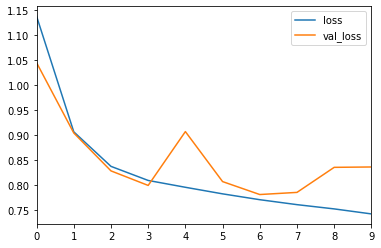

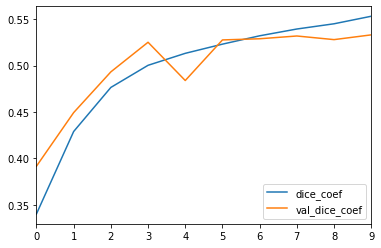

In [0]:
history_df=pd.DataFrame(losses_history.history)
history_df[['loss','val_loss']].plot()
history_df[['dice_coef','val_dice_coef']].plot()

In [0]:
model.load_weights('model.h5')
test_df=[]

for i in range(0,test_imgs.shape[0],1000):
  batch_idx=list(range(i,min(test_imgs.shape[0],i+1000)))
  test_gen=DataGenerator(
      batch_idx,
      df=test_imgs,
      data_df=sample_df,
      function_mode='predict',
      images_base_path='test_images',
      batch_size=1,
      img_dim=(350,525),
      do_reshape=(320,480),
      do_augment=False,
      n_channels=3,
      n_classes=4
  )
  batch_pred_masks=model.predict_generator(test_gen,workers=1,verbose=1)

  for i,j in enumerate(batch_idx):
    img_name=test_imgs['ImageName'].iloc[j]
    img_all_masks_df=sample_df[sample_df['ImageName']==img_name].copy()
    pred_masks=batch_pred_masks[i,].round().astype(int)
    pred_rles=build_all_rles(pred_masks,reshape=(350,525))
    img_all_masks_df['EncodedPixels']=pred_rles
    test_df.append(img_all_masks_df)

698/698 [==============================] - 38s 54ms/step


In [0]:
test_df=pd.concat(test_df)
test_df.drop(columns='ImageName',inplace=True)
test_df.to_csv('submission.csv',index=False)
test_df.head()

,Image_Label,EncodedPixels
0,002f507.jpg_Fish,
1,002f507.jpg_Flower,
2,002f507.jpg_Gravel,80753 3 80765 6 81101 6 81114 10 81448 28 8179...
3,002f507.jpg_Sugar,43522 2 43534 3 43871 5 43882 8 44220 8 44231 ...
4,0035ae9.jpg_Fish,
